# Binary Wet Snow Map Time Series: Upper Tuolmne

In [1]:
import numpy as np
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import contextily as ctx
import xarray as xr
import rioxarray as rxr
import dask_gateway
import sys
sys.path.append('../../../sar_snowmelt_timing')
sys.path.append('../../../../generate_sentinel1_local_incidence_angle_maps')
import s1_rtc_bs_utils
import generate_lia
import pandas as pd
import pytz

import odc.stac,odc
import pystac_client
import planetary_computer

In [2]:
# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# # cluster.scale(20)
# cluster.adapt(minimum=2, maximum=100)

# # # gateway = dask_gateway.Gateway()
# # # cluster_options = gateway.cluster_options()
# # # cluster_options["worker_memory"] = 16
# # # cluster = gateway.new_cluster(cluster_options)
# # # cluster.scale(56)
# # # client = cluster.get_client()

# print(client.dashboard_link)

# Read in bounding box geojson

In [3]:
name = 'Upper Tuolumne'
geojson = 'shapefiles/18040009_HU8_bisect.geojson'     

In [4]:
year=2023

# Get Sentinel-1 data over the bounding box

In [5]:
bbox_gdf = gpd.read_file(geojson)
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_odc_pc(bbox_gdf,start_time=f'{year}-01-01',end_time=f'{year}-12-31',resolution=100,resampling='bilinear',epsg=)

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [6]:
ts_ds = ts_ds.rio.clip(bbox_gdf.geometry.values, bbox_gdf.crs, drop=True)

# Check out the xarray dataarray

In [7]:
ts_ds

<xarray.DataArray (time: 106, band: 2, y: 548, x: 1110)>
dask.array<where, shape=(106, 2, 548, 1110), dtype=float32, chunksize=(100, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y                   (y) float64 4.237e+06 4.236e+06 ... 4.182e+06 4.182e+06
  * x                   (x) float64 7.236e+05 7.236e+05 ... 8.344e+05 8.344e+05
  * time                (time) datetime64[ns] 2023-01-01T01:59:54.071738 ... ...
    sat:orbit_state     (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    sat:relative_orbit  (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
  * band                (band) object 'vh' 'vv'
    spatial_ref         int64 0
Attributes:
    resolution:  100

# Mask out treecover

In [8]:
classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]

In [9]:
worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds)
ts_ds = ts_ds.where(worldcover.isin(classes))

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


# Now let's find the summertime average backscatter for each orbit and polarization

In [10]:
summer = slice(f'{year}-06-01',f'{year}-09-01')

In [11]:
summer_db = ts_ds.sel(time=summer).groupby('sat:relative_orbit').mean()

# Now let's ratio these summer averages from the time series to get ratio images for all polarizations and orbits

In [12]:
ratio_images = ts_ds.groupby('sat:relative_orbit')/summer_db

# Convert to dB

In [13]:
ratio_images = 10.0*np.log10(ratio_images)

# Now we can combine the ratio images from the VV and VH polarizations using the method from Nagler et al. 2016 making use of local incidence angle. See https://www.mdpi.com/2072-4292/8/4/348

In [14]:
#generate_lia.geojson_to_lia_rasters_and_lia_stack(geojson,res=20)

In [42]:
dem = rxr.open_rasterio('dems/dem_UTM.tif')

In [16]:
lia_stack = xr.open_dataarray('lia_maps/lia_stack_orbits_42_64_137_144.nc',decode_coords='all').rio.write_crs(dem.rio.crs)
mean_local_incidence_angles = np.rad2deg(lia_stack)

In [17]:
del dem

In [18]:
# Write crs to LIA raster and reproject to match ratio images
mean_local_incidence_angles = mean_local_incidence_angles.rio.clip(bbox_gdf.geometry.values,bbox_gdf.crs, drop=True)
lia = mean_local_incidence_angles.rio.reproject_match(ratio_images, Resampling = rio.enums.Resampling.bilinear)

In [19]:
# mask out LIA <15 and >75
lia = lia.where((lia>15) & (lia<75))

In [20]:
# Constants to be used in the weights calculation
k = 0.5
theta1 = 20
theta2 = 45

In [21]:
# Weights calculation per relative orbit
W = xr.where(lia<theta1,1,k*(1 + ((theta2-lia)/(theta2-theta1)) ) )
W = xr.where(lia>theta2,k,W)

# Now that we've calculated the weights, let's combine the VV and VH ratio images

In [22]:
# Rc calculation
Rc = W*ratio_images.sel(band='vh').groupby('sat:relative_orbit') + (1-W)*ratio_images.sel(band='vv').groupby('sat:relative_orbit') 

In [23]:
Rc = Rc.rio.write_crs(lia.rio.crs)

In [24]:
Rc

<xarray.DataArray (time: 106, y: 548, x: 1110)>
dask.array<add, shape=(106, 548, 1110), dtype=float64, chunksize=(100, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x                   (x) float64 7.236e+05 7.236e+05 ... 8.344e+05 8.344e+05
  * y                   (y) float64 4.237e+06 4.236e+06 ... 4.182e+06 4.182e+06
    sat:relative_orbit  (time) int64 137 144 42 64 137 144 ... 144 42 64 137 144
  * time                (time) datetime64[ns] 2023-01-01T01:59:54.071738 ... ...
    sat:orbit_state     (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    spatial_ref         int64 0

# Now threshold the images using a threshold of -2dB

In [25]:
binary_wet_snow = xr.where(Rc<-2,1,np.nan)

In [26]:
binary_wet_snow

<xarray.DataArray (time: 106, y: 548, x: 1110)>
dask.array<where, shape=(106, 548, 1110), dtype=float64, chunksize=(100, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x                   (x) float64 7.236e+05 7.236e+05 ... 8.344e+05 8.344e+05
  * y                   (y) float64 4.237e+06 4.236e+06 ... 4.182e+06 4.182e+06
    sat:relative_orbit  (time) int64 137 144 42 64 137 144 ... 144 42 64 137 144
  * time                (time) datetime64[ns] 2023-01-01T01:59:54.071738 ... ...
    sat:orbit_state     (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    spatial_ref         int64 0

# Remove single outlier pixels

In [27]:
# 3x3 median filter:toggle min_periods, should change to 1 for single pixel outlier
binary_wet_snow = binary_wet_snow.rolling({"x":3,"y":3},center=True,min_periods=1).median()

## Mask out areas with no snow

In [28]:
# def get_modis_snowcover(bbox_gdf,start_time='2019-01-01',end_time='2019-12-31', resampling=None):
#     import odc.stac,odc
#     import pystac_client
#     import planetary_computer
    
#     catalog = pystac_client.Client.open(
#     "https://planetarycomputer.microsoft.com/api/stac/v1",
#     modifier=planetary_computer.sign_inplace,)
#     bbox = bbox_gdf.total_bounds
#     search = catalog.search(collections=["modis-10A2-061"], bbox=bbox, datetime=f"{start_time}/{end_time}",limit=1000)
#     items = search.item_collection()

#     ds = odc.stac.load(
#     search.get_items(), 
#     bands="Maximum_Snow_Extent",
#     resolution=500)
    
#     bounding_box_utm_gf = bbox_gdf.to_crs(ds.rio.crs)
#     xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]

#     scenes = ds['Maximum_Snow_Extent'].sel(x=slice(xmin,xmax),y=slice(ymin,ymax))
    
#     return scenes

In [29]:
start_time = f'{year}-01-01'
end_time= f'{year}-12-31'

In [30]:
catalog = pystac_client.Client.open(
"https://planetarycomputer.microsoft.com/api/stac/v1",
modifier=planetary_computer.sign_inplace,)
bbox = bbox_gdf.total_bounds
search = catalog.search(collections=["modis-10A2-061"], bbox=bbox, datetime=f"{start_time}/{end_time}",limit=1000)
items = search.item_collection()

In [31]:
modis_snow = odc.stac.load(
    search.get_items(), 
    bands="Maximum_Snow_Extent",
    like = ts_ds, 
    resampling = "nearest")['Maximum_Snow_Extent']

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [32]:
#modis_snow = get_modis_snowcover(bbox_gdf,.rio.reproject_match(binary_wet_snow,Resampling = rio.enums.Resampling.mode)

In [33]:
modis_snow_interp = modis_snow.interp_like(binary_wet_snow,method='nearest')

In [34]:
modis_no_snow = xr.where(modis_snow_interp==25,1,0)

In [35]:
binary_wet_snow = binary_wet_snow.where(modis_no_snow==0)

In [36]:
binary_wet_snow_bool = xr.where(binary_wet_snow==1,1,0).where(ratio_images.sel(band='vh').notnull().compute(),other=-1,drop=True).astype(np.int8).rio.write_crs(ratio_images.rio.crs).rio.write_nodata(-1)

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [37]:
binary_wet_snow_bool.to_netcdf(f'output/binary_wetsnow_upper_tuolumne_{year}_100m.nc')

# Let's view a time series of binary wet snow maps

In [38]:
binary = xr.open_dataarray(f'output/binary_wetsnow_upper_tuolumne_{year}_100m.nc',decode_coords='all', mask_and_scale=True)

<Axes: title={'center': 'sat:relative_orbit = 137, time = 2023-01-01T01:...'}, xlabel='x', ylabel='y'>

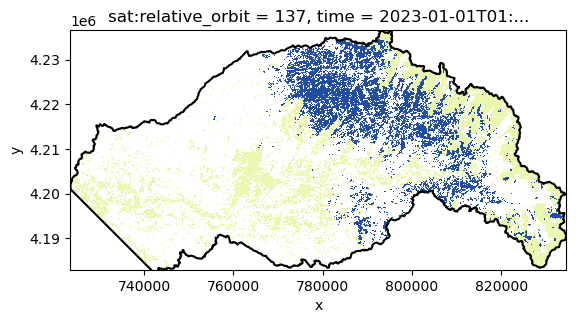

In [39]:
f,ax=plt.subplots()
binary.isel(time=0).plot(ax=ax,cmap='YlGnBu',vmin=-0.2,vmax=1.3, add_colorbar=False)
bbox_gdf.to_crs(binary.rio.crs).geometry.boundary.plot(ax=ax,color='black')

In [40]:
watershed_boundary = bbox_gdf.to_crs(binary.rio.crs).geometry.boundary

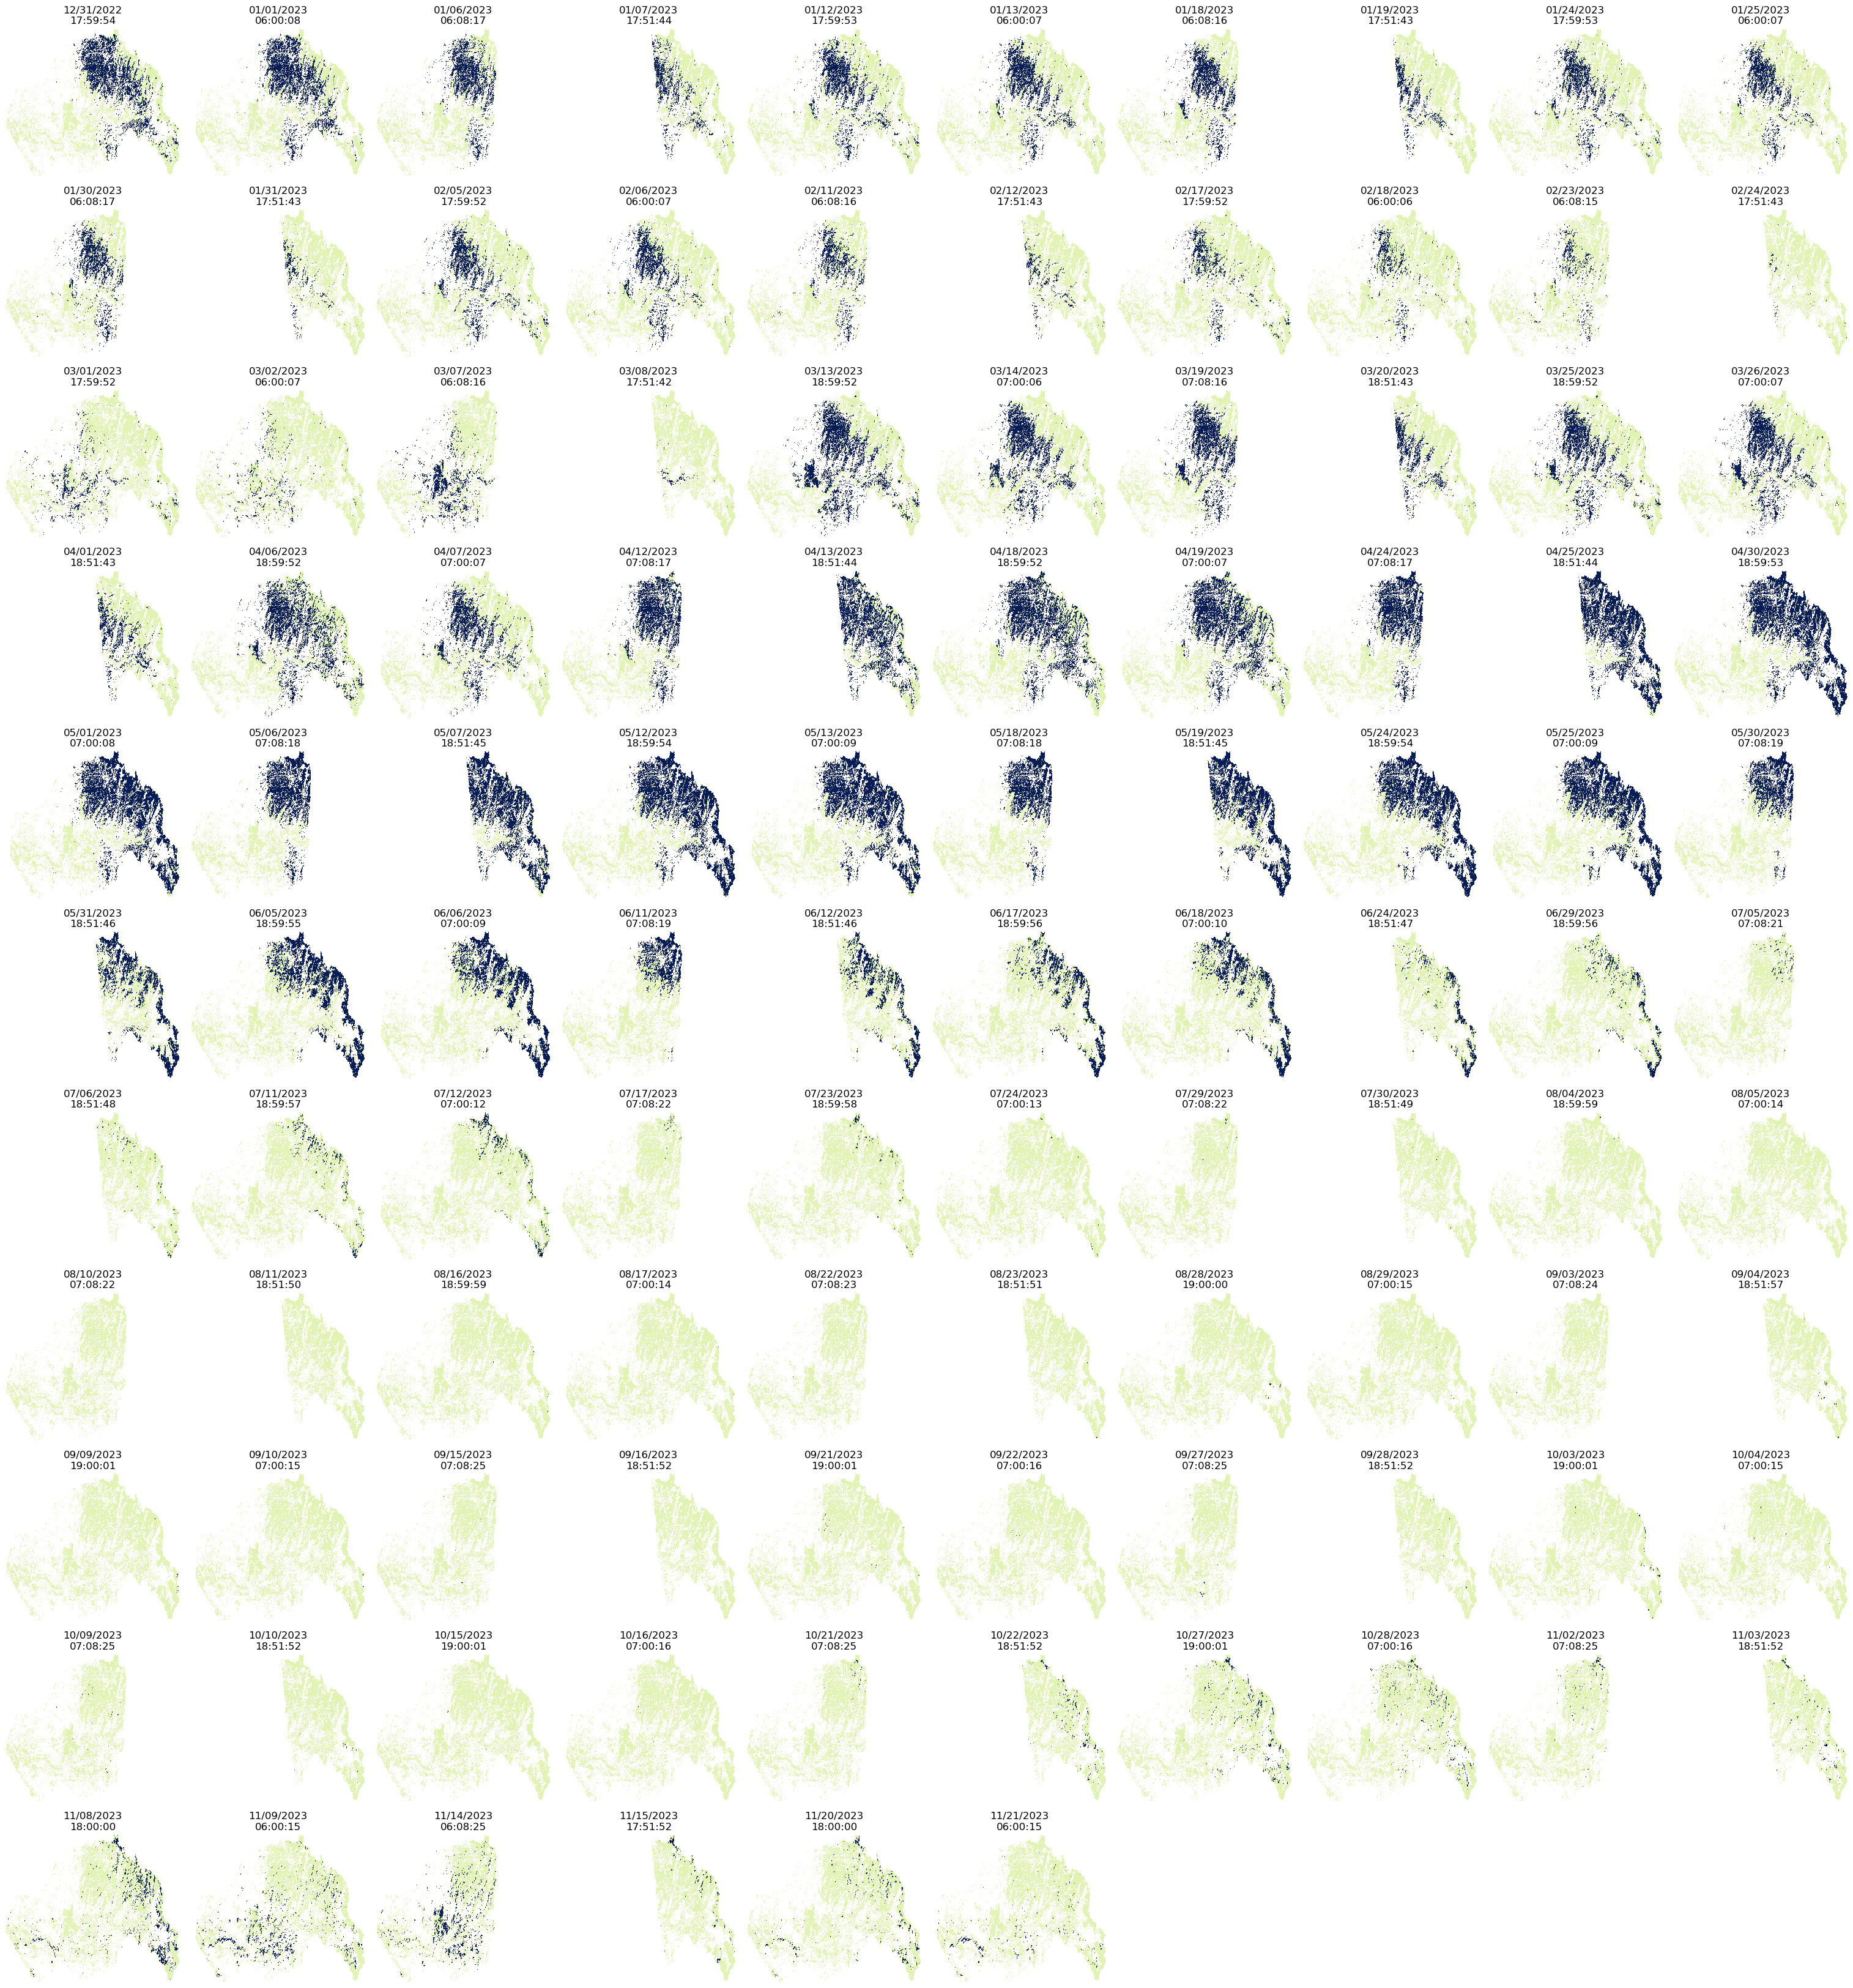

In [41]:
local = pytz.timezone("America/Los_Angeles") 
days = [pytz.utc.localize(time).astimezone(local).strftime("%m/%d/%Y") for time in pd.to_datetime(binary.time.values)]
times = [pytz.utc.localize(time).astimezone(local).strftime("%H:%M:%S") for time in pd.to_datetime(binary.time.values)]

b = binary.plot(col='time',col_wrap=10,cmap='YlGnBu',vmin=-0.2,vmax=1.2, add_colorbar=False)
for ax, day, time in zip(b.axes.flat, days, times):
    #ctx.add_basemap(ax=ax, crs=binary_wet_snow.rio.crs, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.jpg?api_key=25e388f2-410e-435e-a401-ca7ef32eada0', attribution=False)
    ax.set_title(f'{day}\n{time}')
    #watershed_boundary.plot(ax=ax,color='black')
    ax.axis('off')